In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43331")
client

<Client: 'tcp://127.0.0.1:43331' processes=8 threads=40, memory=157.39 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import xrft
import xwavelet
from scipy.interpolate import interp2d, bisplrep, bisplev, griddata
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/Wavelet-spectrum/'
tdgs = '/tank/tdgs/tuchida/TWA'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1421280,1576800+dnf,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0
ntimes[yystart,:]

array([1421280, 1423440, 1425600, 1427760, 1429920, 1432080, 1434240,
       1436400, 1438560, 1440720, 1442880, 1445040, 1447200, 1449360,
       1451520, 1453680, 1455840, 1458000, 1460160, 1462320, 1464480,
       1466640, 1468800, 1470960, 1473120, 1475280, 1477440, 1479600,
       1481760, 1483920, 1486080, 1488240, 1490400, 1492560, 1494720,
       1496880, 1499040, 1501200, 1503360, 1505520, 1507680, 1509840,
       1512000, 1514160, 1516320, 1518480, 1520640, 1522800, 1524960,
       1527120, 1529280, 1531440, 1533600, 1535760, 1537920, 1540080,
       1542240, 1544400, 1546560, 1548720, 1550880, 1553040, 1555200,
       1557360, 1559520, 1561680, 1563840, 1566000, 1568160, 1570320,
       1572480, 1574640, 1576800])

In [6]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]

xo = 50e3
s = xr.DataArray(np.arange(.5,10.5,.5), dims=['scale'], 
                 coords={'scale':np.arange(.5,10.5,.5)}
                )

## $$\Pi(k) = -\int_{\kappa>k} \mathcal{R}\left[\hat{{\bf u}'}\cdot\widehat{({\bf u}\cdot\nabla{\bf u})'}^*\right]\, d\kappa$$

# Wavelet
## Native grid

<xarray.DataArray (nmemb: 48, Z: 2, angle: 18, scale: 20)>
array([[[[-2.72720723e-12,  5.14857851e-10, -4.88394901e-10, ...,
          -8.01003475e-06, -8.33841335e-06, -8.61667825e-06],
         [-1.33150477e-12, -2.23678926e-11,  1.88025949e-10, ...,
           4.06648196e-06,  4.71373406e-06,  5.21762965e-06],
         [-1.14251376e-13,  1.46190985e-11,  5.52865568e-10, ...,
           1.46505364e-05,  1.62962357e-05,  1.76182512e-05],
         ...,
         [ 1.07197410e-11, -7.81587490e-10,  7.97728008e-09, ...,
           4.83616463e-06,  4.41973684e-06,  4.08700457e-06],
         [ 2.10469166e-11,  4.58587731e-09,  5.47229160e-08, ...,
          -2.12247449e-06, -2.78000183e-06, -3.29940117e-06],
         [ 1.55671213e-11,  4.67098160e-09,  3.14352911e-08, ...,
          -1.07717667e-05, -1.15280307e-05, -1.21304939e-05]],

        [[ 1.57234950e-16, -5.99400265e-14,  1.36242817e-11, ...,
          -4.88526545e-08, -5.50849478e-08, -5.99301687e-08],
         [ 1.98601860e-17,  1

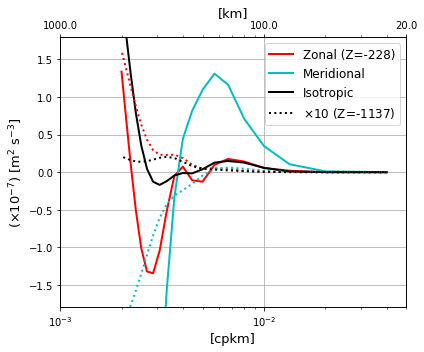

<xarray.DataArray (nmemb: 48, Z: 2, angle: 18, scale: 20)>
array([[[[-9.66451439e-15,  1.06469006e-11, -6.91172847e-10, ...,
          -4.73993372e-07, -4.40065986e-07, -4.12258678e-07],
         [-8.55110003e-14, -2.16593623e-12, -4.36383594e-10, ...,
          -3.49021986e-07, -3.22030630e-07, -3.02977736e-07],
         [-2.23651782e-13,  3.21016133e-12, -3.70119459e-11, ...,
           1.91113031e-07,  1.95215402e-07,  1.94462650e-07],
         ...,
         [-1.67464841e-13,  2.58975679e-10, -3.01891837e-09, ...,
           8.94360233e-07,  9.32015681e-07,  9.70173577e-07],
         [-1.08689678e-13,  2.48895388e-10, -3.59060588e-10, ...,
           7.08643011e-07,  7.36816582e-07,  7.65780014e-07],
         [ 1.20156909e-14,  1.28249204e-10, -3.49927822e-10, ...,
           6.09211905e-08,  9.07523100e-08,  1.18715394e-07]],

        [[-3.45909220e-16, -2.54561036e-13,  3.38840992e-11, ...,
           9.58593062e-09,  1.06506866e-08,  1.12691839e-08],
         [-4.00352906e-16,  2

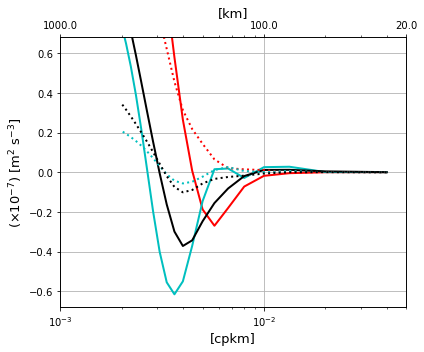

<xarray.DataArray (nmemb: 48, Z: 2, angle: 18, scale: 20)>
array([[[[-1.41207605e-16,  4.28909838e-13,  1.99174078e-12, ...,
          -5.25978963e-08, -1.00037111e-08,  3.91016053e-08],
         [-1.25334139e-15,  9.94091653e-12,  1.61234757e-10, ...,
           4.14543153e-07,  5.50757224e-07,  6.81932759e-07],
         [-1.63848678e-15,  2.60302271e-12, -1.15504696e-10, ...,
           6.35182931e-07,  8.05553547e-07,  9.67070969e-07],
         ...,
         [ 4.66187211e-15,  8.72933719e-12, -1.31686484e-10, ...,
           1.58215676e-07,  1.99121566e-07,  2.37315492e-07],
         [ 2.84823624e-15,  1.50878611e-12, -6.02589440e-11, ...,
           7.27242217e-07,  7.66608783e-07,  8.07562491e-07],
         [-1.91896525e-16, -4.94288503e-13,  7.27551014e-11, ...,
           1.65327709e-07,  1.77994856e-07,  1.97815944e-07]],

        [[ 2.81838970e-18,  7.79381877e-15,  1.73700920e-12, ...,
          -7.66122192e-09, -7.74286999e-09, -7.45903960e-09],
         [-2.46897972e-18, -5

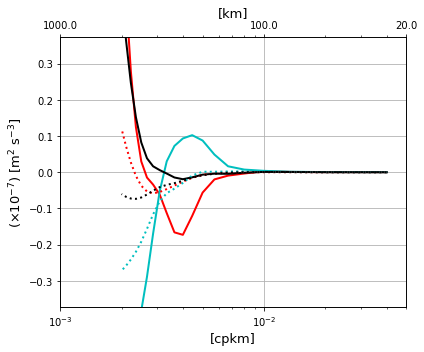

<xarray.DataArray (nmemb: 48, Z: 2, angle: 18, scale: 20)>
array([[[[ 2.34540307e-16,  7.25086554e-13,  3.54082078e-12, ...,
           2.15847441e-09,  3.29728743e-09,  4.68215748e-09],
         [ 2.24898423e-16,  4.62358256e-14, -2.44071532e-12, ...,
           2.28091508e-08,  2.33692714e-08,  2.40974376e-08],
         [ 7.99681636e-17,  4.05309414e-14,  1.85193174e-12, ...,
           3.13659457e-08,  3.14255601e-08,  3.17019692e-08],
         ...,
         [ 2.58091898e-15,  2.02852088e-12, -2.99165860e-11, ...,
           2.72739652e-09,  5.14450202e-09,  7.75713344e-09],
         [ 1.89394631e-15,  3.12257891e-12, -1.33844999e-11, ...,
          -9.87416649e-11,  3.55555030e-09,  7.17812490e-09],
         [ 7.49089161e-16,  1.88138788e-12,  4.07529387e-12, ...,
          -3.29881507e-10,  2.55485057e-09,  5.55352226e-09]],

        [[ 1.71201266e-17,  8.71916299e-15,  3.90504246e-14, ...,
          -1.20689394e-11, -7.50039574e-12,  3.30910693e-12],
         [ 2.41955929e-18,  3

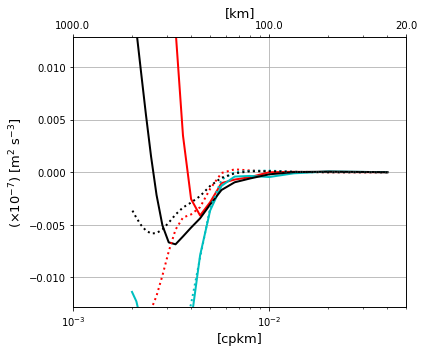

<xarray.DataArray (nmemb: 48, Z: 2, angle: 18, scale: 20)>
array([[[[-5.17788986e-19,  8.96337625e-14, -1.31203808e-11, ...,
           1.46965141e-08,  2.19430291e-08,  2.86970989e-08],
         [-7.47767955e-18,  6.81621651e-14, -1.71934817e-11, ...,
           3.85386333e-08,  4.60843897e-08,  5.25732223e-08],
         [ 1.45615695e-17,  1.75892209e-13,  2.38044457e-12, ...,
           2.78949441e-08,  3.09733483e-08,  3.36830818e-08],
         ...,
         [ 4.97653809e-16,  9.64503598e-12,  1.23935480e-10, ...,
           1.27977282e-08,  1.65036026e-08,  1.91166525e-08],
         [ 1.18926291e-16,  5.81098611e-12,  1.48030647e-10, ...,
          -1.21061644e-08, -1.18564339e-08, -1.16602242e-08],
         [ 1.99150455e-17,  9.32232312e-13, -7.01664201e-13, ...,
          -2.07636986e-08, -2.01229215e-08, -1.89133470e-08]],

        [[-2.71849420e-20,  1.01647490e-14,  1.26111106e-14, ...,
           1.12952468e-09,  1.35091867e-09,  1.52517852e-09],
         [ 6.35087410e-19, -1

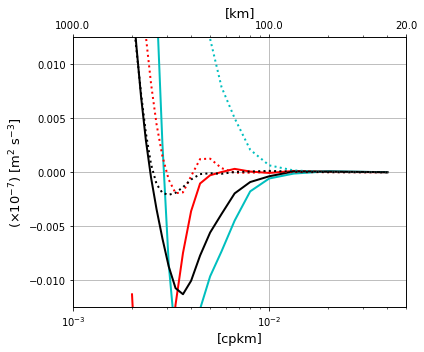

<xarray.DataArray (nmemb: 48, Z: 2, angle: 18, scale: 20)>
array([[[[-9.26360005e-16,  2.92523741e-12,  2.50708445e-12, ...,
          -1.60702009e-08, -1.65258785e-08, -1.68791753e-08],
         [-1.13181875e-14, -7.37527761e-14, -4.97066115e-11, ...,
          -7.33002439e-09, -7.74367799e-09, -8.02176669e-09],
         [-1.77015760e-14, -5.52707143e-12, -6.44425547e-11, ...,
           3.27031499e-09,  3.46285101e-09,  3.80267979e-09],
         ...,
         [-2.28918764e-17,  1.23116411e-12,  2.98277528e-11, ...,
           9.58070249e-09,  1.10136811e-08,  1.22077697e-08],
         [ 5.89329390e-17,  1.50918066e-12,  2.90493564e-11, ...,
           4.15571524e-09,  5.28047321e-09,  6.17871019e-09],
         [ 7.51032976e-17,  1.96962059e-12,  4.25794137e-11, ...,
          -1.23513144e-08, -1.21221547e-08, -1.19416353e-08]],

        [[ 3.26468003e-17, -9.23649629e-15, -2.86744887e-13, ...,
          -3.41048573e-10, -4.13411581e-10, -4.81801448e-10],
         [ 2.09852997e-17,  8

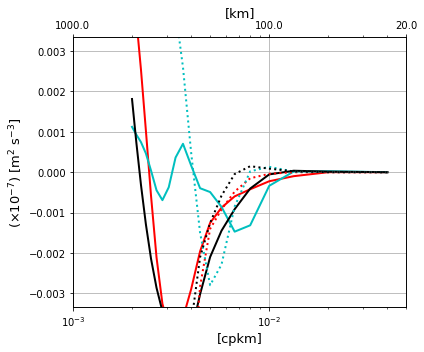

In [7]:
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
xchunk = 100
ychunk = 100

yy = yystart

for reg in range(len(xs)):
    for year in years[yystart:]:
        if year == years[yystart]:
            mtimes = ntimes[yy,:dd+1]
        else:
            mtimes = ntimes[yy]
        for itime in mtimes:

            dsb = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Ensemble-mean/%2dmembers/15N-50N_%010d.zarr'
                                       % (year,len(nmembs),itime))
                              ).isel(time=0
                                    ).sel(YC=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                          YG=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                          XC=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1),
                                          XG=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1)
                                         ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})

            for nmemb in nmembs:
                if nmemb == 0:
                    ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                 % (nmemb,year)), 
                                         grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                         prefix=['diag_ocnTave'], delta_t=2e2,
                                         iters=itime, 
                                        ).sel(YC=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                              YG=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                              XC=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1),
                                              XG=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1)
                                             ).isel(time=0
                                                   ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                else:
                    ds = xr.concat([ds, 
                                    open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                            % (nmemb,year)), 
                                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                    prefix=['diag_ocnTave'], delta_t=2e2,
                                                    iters=itime, 
                                                   ).sel(YC=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                                         YG=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                                         XC=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1),
                                                         XG=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1)
                                                        ).isel(time=0
                                                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                                   ], dim='nmemb')

            # ds = ds.chunk({'nmemb':6})
            ds.coords['nmemb'] = ('nmemb',nmembs)

            grid = Grid(ds, periodic=[])
            
            Au = ((grid.interp(ds.UVEL.where(ds.maskW!=0.),'X',boundary='extend').isel(Z=[14,24])
                   * grid.diff((ds.UVEL*ds.dyG).where(ds.maskW!=0.),'X',boundary='extend').isel(Z=[14,24])
                   + grid.interp(ds.VVEL.where(ds.maskS!=0.) 
                                 * grid.interp(grid.diff((ds.UVEL*ds.dxC).where(ds.maskW!=0.),'Y',boundary='extend'),
                                               'X',boundary='extend'),
                                 'Y',boundary='extend').isel(Z=[14,24])
                  ) / ds.rA).isel(YC=slice(1,-1),XC=slice(1,-1)).reset_coords(drop=True)
            Av = ((grid.interp(ds.UVEL.where(ds.maskW!=0.) 
                               * grid.interp(grid.diff((ds.VVEL*ds.dyC).where(ds.maskS!=0.),'X',boundary='extend'),
                                             'Y',boundary='extend'),
                               'X',boundary='extend').isel(Z=[14,24])
                   + grid.interp(ds.VVEL.where(ds.maskS!=0.),'Y',boundary='extend').isel(Z=[14,24])
                   * grid.diff((ds.VVEL*ds.dxG).where(ds.maskS!=0.),'Y',boundary='extend').isel(Z=[14,24])
                  ) / ds.rA).isel(YC=slice(1,-1),XC=slice(1,-1)).reset_coords(drop=True)
#             print(Au,Av)
            
            up = grid.interp((ds.UVEL - dsb.UVEL).where(ds.maskW!=0.),
                             'X',boundary='extend'
                            ).isel(Z=[14,24],YC=slice(1,-1),XC=slice(1,-1)).chunk({'YC':-1,'XC':-1})
            vp = grid.interp((ds.VVEL - dsb.VVEL).where(ds.maskS!=0.),
                             'Y',boundary='extend'
                            ).isel(Z=[14,24],YC=slice(1,-1),XC=slice(1,-1)).chunk({'YC':-1,'XC':-1})
            Aup = (Au - Au.mean('nmemb',skipna=True))
            Avp = (Av - Av.mean('nmemb',skipna=True))

            dx = grid.interp(ds.dxC,'X',boundary='extend').mean(skipna=True)
            dy = grid.interp(ds.dyC,'Y',boundary='extend').mean(skipna=True)
            N = up.shape
            up = xr.DataArray(up.data, dims=up.dims, 
                              coords={'nmemb':up.nmemb,'Z':up.Z,
                                      'YC':np.arange(0,N[-2]*dy,dy),
                                      'XC':np.arange(0,N[-1]*dx,dx)}
                             )
            vp = xr.DataArray(vp.data, dims=vp.dims, 
                              coords={'nmemb':vp.nmemb,'Z':vp.Z,
                                      'YC':np.arange(0,N[-2]*dy,dy),
                                      'XC':np.arange(0,N[-1]*dx,dx)}
                             )
            Aup = xr.DataArray(Aup.data, dims=up.dims, 
                               coords={'nmemb':up.nmemb,'Z':up.Z,
                                       'YC':np.arange(0,N[-2]*dy,dy),
                                       'XC':np.arange(0,N[-1]*dx,dx)}
                              )
            Avp = xr.DataArray(Avp.data, dims=vp.dims, 
                               coords={'nmemb':vp.nmemb,'Z':vp.Z,
                                       'YC':np.arange(0,N[-2]*dy,dy),
                                       'XC':np.arange(0,N[-1]*dx,dx)}
                              )
            
            ntheta=36
            iso_csUA = xwavelet.wvlt_cross_spectrum(
                    up, Aup, s, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
            iso_csVA = xwavelet.wvlt_cross_spectrum(
                    vp, Avp, s, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
            
#             pi = -((iso_csUA + iso_csVA)*np.diff(iso_csUA.scale**-1)[0])[::-1].cumsum('scale')[::-1]
            pi = ((iso_csUA + iso_csVA)*np.diff(iso_csUA.scale**-1)[0]).cumsum('scale').compute()
            print(pi)
                  
            fig, ax = plt.subplots(figsize=(6,5))
            fig.set_tight_layout(True)
#             ax2 = ax.twinx()
            ax3 = ax.twiny()
#             ax.plot(np.linspace(1e-3,5e-2,10), np.zeros(10), 'k', alpha=.6, lw=1)
            ax.plot((iso_csUA.scale)**-1*1e3, pi.isel(angle=0,Z=0).mean(['nmemb'])*1e7,
                    'r', lw=2, label=r"Zonal (Z=-228)")
            ax.plot((iso_csUA.scale)**-1*1e3, pi.isel(angle=ntheta//2//2-1,Z=0).mean(['nmemb'])*1e7,
                    'c', lw=2, label=r"Meridional")
            ax.plot((iso_csUA.scale)**-1*1e3, pi.isel(Z=0).mean(['nmemb','angle'])*1e7,
                    'k', lw=2, label=r"Isotropic")
            ax.plot((iso_csUA.scale)**-1*1e3, pi.isel(angle=0,Z=1).mean(['nmemb'])*1e8,
                    'r:', lw=2)
            ax.plot((iso_csUA.scale)**-1*1e3, pi.isel(angle=ntheta//2//2-1,Z=1).mean(['nmemb'])*1e8,
                    'c:', lw=2)
            ax.plot((iso_csUA.scale)**-1*1e3, pi.isel(Z=1).mean(['nmemb','angle'])*1e8,
                    'k:', lw=2, label=r"$\times 10$ (Z=-1137)")
#             ax.plot((iso_psUA.scale)**-1*1e3, ((iso_psU.scale/xo)**-1)**-3*6e-2, 
#                      ls='--', c='grey', alpha=.8, label=r"$k^{-3}$")
#             ax.plot((iso_psUA.scale)**-1*1e3, ((iso_psU.scale/xo)**-1)**-(13/3)*6e-2, 
#                      ls='-.', c='grey', alpha=.8, label=r"$k^{-13/3}$")
#             ax2.plot((iso_psUA.scale)**-1*1e3, ((iso_psU.scale/xo)**-1)**-3*6e-2, 
#                      ls='--', c='grey', alpha=0)
            ax.set_xscale('log')
#             ax.set_yscale('log')
#             ax2.set_xscale('log')
            ax3.set_xscale('log')
#             ax2.set_yscale('log')
            ax.set_xlim([1e-3,5e-2])
            if reg < 5:
                ax.set_ylim([-np.abs(pi.isel(Z=0,scale=-1).mean(['nmemb','angle'])*1e7*.75),
                             np.abs(pi.isel(Z=0,scale=-1).mean(['nmemb','angle'])*1e7*.75)])
            else:
                ax.set_ylim([-np.abs(pi.isel(Z=0).mean(['nmemb','angle'])).max()*1e7*.75,
                             np.abs(pi.isel(Z=0).mean(['nmemb','angle'])).max()*1e7*.75])
            ax3.set_xlim([1e-3,5e-2])
            ax3.set_xticks([1e-3,1e-2,5e-2])
            ax3.set_xticklabels([1e3,1e2,2e1])
            ax.set_xlabel(r"[cpkm]", fontsize=13)
            ax3.set_xlabel(r"[km]", fontsize=13)
            ax.set_ylabel(r"($\times 10^{-7}$) [m$^2$ s$^{-3}$]", fontsize=13)
#             ax2.set_ylabel(r"(Z=-1137) [m$^2$ s$^{-3}$]", fontsize=13)
            ax.grid(True)
#             align_yaxis(ax, 0, ax2, 0)
            if reg == 0:
                ax.legend(loc='upper right', fontsize=12)
#                 ax2.legend(loc='upper right', fontsize=12)
            plt.savefig(op.join('/tank/topog/tuchida/Wavelet-spectrum/Figs/KE-specflux_Region%02d.pdf' % reg))
        plt.show()

<xarray.DataArray (nmemb: 48, angle: 18, scale: 20)>
array([[[-1.07639645e-10, -1.42810453e-08, -6.47102352e-08, ...,
         -1.46787074e-05, -1.49258651e-05, -1.51077098e-05],
        [-1.30780904e-11, -8.51920708e-10,  2.73034290e-09, ...,
          9.13940552e-06,  1.06898872e-05,  1.19538338e-05],
        [ 5.39695391e-13,  7.72150218e-11,  5.82404665e-09, ...,
          2.75309934e-05,  3.07054655e-05,  3.32929956e-05],
        ...,
        [ 1.82076557e-09,  7.58214664e-08,  4.44345443e-07, ...,
          7.52152155e-06,  6.88565787e-06,  6.35595031e-06],
        [ 2.53400219e-09,  8.79768561e-08,  3.32489848e-07, ...,
         -8.25855309e-06, -9.23577314e-06, -1.00104696e-05],
        [ 7.06513188e-10, -3.54702872e-08, -2.42980732e-07, ...,
         -2.39755577e-05, -2.50797904e-05, -2.59381109e-05]],

       [[-1.04828997e-12, -8.87303934e-11, -2.92697252e-10, ...,
         -5.50485150e-07, -1.88811378e-07,  1.30549748e-07],
        [-1.76672743e-13, -6.83213135e-11, -2.9295

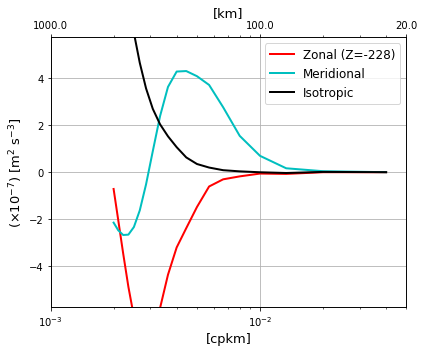

<xarray.DataArray (nmemb: 48, angle: 18, scale: 20)>
array([[[ 5.70276088e-14,  4.82734300e-11,  6.83186321e-10, ...,
         -1.19785798e-06, -1.13253800e-06, -1.08049822e-06],
        [ 2.85320218e-14,  5.00940545e-12,  1.88983883e-10, ...,
         -1.08103977e-06, -1.02881306e-06, -9.93394257e-07],
        [ 7.13029463e-13,  8.73291220e-12,  5.86449058e-10, ...,
          3.57190663e-08,  4.35604450e-08,  4.05860382e-08],
        ...,
        [ 2.32130456e-12,  5.20606335e-10, -6.30530947e-10, ...,
          2.03496551e-06,  2.10879539e-06,  2.18617096e-06],
        [ 4.32905477e-13,  3.26169086e-10,  2.99356467e-10, ...,
          1.63273191e-06,  1.68512160e-06,  1.73969143e-06],
        [-5.68152133e-13,  2.00344718e-10,  1.17498095e-09, ...,
          1.95496503e-07,  2.52750013e-07,  3.05451151e-07]],

       [[ 3.70543291e-12,  1.83328099e-10,  1.11447645e-08, ...,
          4.99786250e-07,  4.99914390e-07,  5.02347523e-07],
        [ 6.16104781e-11, -1.36678351e-09, -2.3047

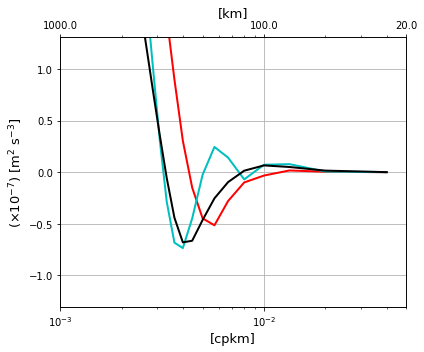

<xarray.DataArray (nmemb: 48, angle: 18, scale: 20)>
array([[[ 3.81969650e-14, -5.25958135e-13,  1.71767954e-10, ...,
         -3.01898392e-08,  3.40224795e-08,  1.04065221e-07],
        [ 1.71911167e-14,  1.47353646e-11,  3.02528286e-10, ...,
          7.32140168e-07,  9.44868107e-07,  1.14071832e-06],
        [-2.65640192e-14,  1.65115494e-11,  5.40596074e-11, ...,
          1.10876474e-06,  1.37953577e-06,  1.62619327e-06],
        ...,
        [-3.91715445e-15,  8.65147583e-12, -2.75380385e-10, ...,
         -2.14024814e-09,  5.43898505e-08,  1.09350435e-07],
        [-1.26793692e-14,  3.26000973e-11,  7.85102548e-11, ...,
          1.06809324e-06,  1.12809666e-06,  1.19100433e-06],
        [-8.37164038e-15,  9.39535255e-12,  1.32510206e-10, ...,
          3.46284638e-07,  3.69371425e-07,  4.02381362e-07]],

       [[-1.61047574e-14, -2.03137766e-12, -1.64388907e-11, ...,
          2.74794202e-07,  3.81752859e-07,  4.92848933e-07],
        [ 5.12888809e-14, -1.42988294e-12,  4.1084

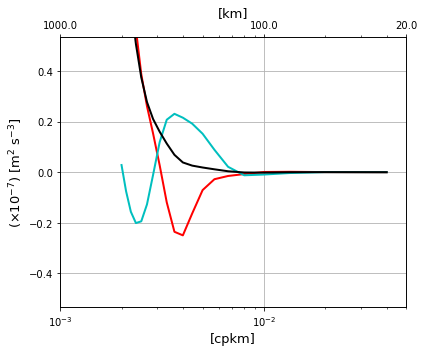

<xarray.DataArray (nmemb: 48, angle: 18, scale: 20)>
array([[[ 1.94695474e-16,  2.28706103e-11,  1.23984454e-10, ...,
          4.57543811e-09,  7.03193279e-09,  1.01429730e-08],
        [-2.80722087e-15,  1.50539512e-11,  7.68828046e-11, ...,
          3.11246163e-08,  3.25672199e-08,  3.44278301e-08],
        [ 2.07626559e-15,  2.60225103e-12,  6.63237430e-11, ...,
          4.25785230e-08,  4.39466353e-08,  4.64581305e-08],
        ...,
        [ 1.89138067e-15,  8.73267208e-13, -8.45442693e-11, ...,
          1.06697540e-10,  6.33474990e-09,  1.35121607e-08],
        [-3.43013462e-15,  1.40250121e-11,  4.22944336e-11, ...,
         -4.09937161e-09,  6.28878914e-09,  1.74067397e-08],
        [-1.24314456e-15,  1.98135229e-11,  1.49196026e-10, ...,
         -1.54776698e-09,  6.74285543e-09,  1.59601531e-08]],

       [[ 6.16657082e-15, -1.13983826e-12, -8.18726268e-12, ...,
          1.30568526e-08,  1.70253237e-08,  2.02160312e-08],
        [ 6.25095589e-15, -3.09104982e-12,  2.4542

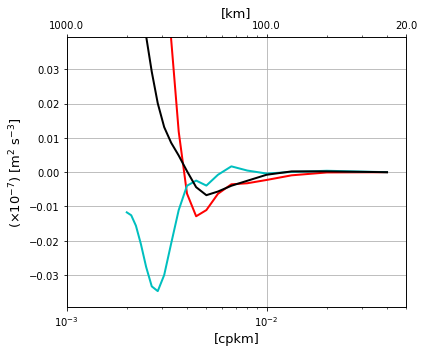

<xarray.DataArray (nmemb: 48, angle: 18, scale: 20)>
array([[[ 4.62482807e-15, -1.59240064e-12, -3.01851939e-10, ...,
         -1.86784505e-08, -1.25601847e-08, -7.56764663e-09],
        [ 3.36129646e-16,  1.52763852e-12, -2.92392705e-11, ...,
          7.35966867e-08,  8.57731161e-08,  9.43982021e-08],
        [-1.89314302e-15,  9.33089066e-13,  9.78672812e-12, ...,
          7.98906691e-08,  9.28051261e-08,  1.02388793e-07],
        ...,
        [ 3.88161452e-14,  9.92788612e-11, -7.31188509e-11, ...,
         -2.46376086e-08, -1.83743545e-08, -1.34623447e-08],
        [ 5.27667940e-14,  1.18306531e-10, -1.94086675e-10, ...,
         -3.96670670e-08, -3.86552251e-08, -3.72789261e-08],
        [ 1.58474441e-14,  6.57421906e-12, -5.68621228e-10, ...,
         -9.67696474e-08, -9.78373078e-08, -9.77206061e-08]],

       [[ 4.69898729e-15,  2.72972539e-13,  4.55797732e-11, ...,
         -1.09123726e-07, -1.16744308e-07, -1.23725020e-07],
        [ 2.89516561e-14,  2.81700138e-13,  6.0705

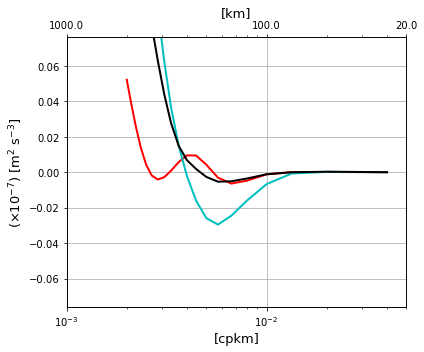

<xarray.DataArray (nmemb: 48, angle: 18, scale: 20)>
array([[[ 6.08733718e-14, -4.06172858e-12, -3.34319702e-11, ...,
         -2.18726951e-08, -2.23423512e-08, -2.23840611e-08],
        [ 7.54751879e-13,  1.68495952e-11,  7.83233436e-11, ...,
         -2.91626340e-08, -2.84496406e-08, -2.73308383e-08],
        [ 1.04918301e-12,  1.00549683e-11,  1.47301930e-10, ...,
          1.01874078e-08,  1.04368913e-08,  1.08779884e-08],
        ...,
        [-6.55227427e-16, -5.11871780e-14, -9.87813948e-12, ...,
          2.51271056e-08,  2.79212614e-08,  3.01757186e-08],
        [ 5.56353288e-15,  1.31519171e-12, -3.60479015e-11, ...,
          1.44588906e-08,  1.57723815e-08,  1.67955452e-08],
        [-5.20536144e-15, -1.75625187e-13, -8.60209454e-11, ...,
         -6.22775552e-09, -6.32384825e-09, -6.37835171e-09]],

       [[-5.64566608e-16,  6.95992803e-12,  1.89610077e-10, ...,
          4.40749265e-09,  7.20658465e-09,  8.44150501e-09],
        [ 1.11500199e-14, -1.21317189e-12,  1.4082

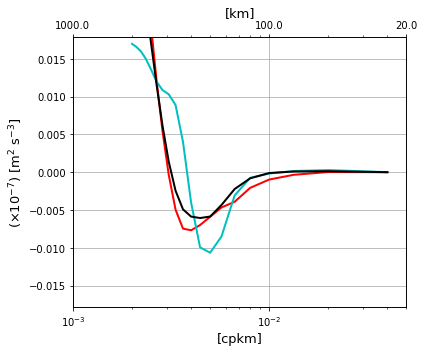

In [10]:
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
xchunk = 100
ychunk = 100

yy = yystart

for reg in range(len(xs)):
    for year in years[yystart:]:
        if year == years[yystart]:
            mtimes = ntimes[yy,:dd+1]
        else:
            mtimes = ntimes[yy]
        for itime in mtimes:

            dsb = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Ensemble-mean/%2dmembers/15N-50N_%010d.zarr'
                                       % (year,len(nmembs),itime))
                              ).isel(time=0
                                    ).sel(YC=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                          YG=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                          XC=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1),
                                          XG=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1)
                                         ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})

            for nmemb in nmembs:
                if nmemb == 0:
                    ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                 % (nmemb,year)), 
                                         grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                         prefix=['diag_ocnTave'], delta_t=2e2,
                                         iters=itime, 
                                        ).sel(YC=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                              YG=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                              XC=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1),
                                              XG=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1)
                                             ).isel(time=0
                                                   ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                else:
                    ds = xr.concat([ds, 
                                    open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                            % (nmemb,year)), 
                                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                    prefix=['diag_ocnTave'], delta_t=2e2,
                                                    iters=itime, 
                                                   ).sel(YC=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                                         YG=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                                         XC=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1),
                                                         XG=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1)
                                                        ).isel(time=0
                                                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                                   ], dim='nmemb')

            # ds = ds.chunk({'nmemb':6})
            ds.coords['nmemb'] = ('nmemb',nmembs)

            grid = Grid(ds, periodic=[])
            
            Au = ((grid.interp(ds.UVEL.where(ds.maskW!=0.),'X',boundary='extend').isel(Z=0)
                   * grid.diff((ds.UVEL*ds.dyG).where(ds.maskW!=0.),'X',boundary='extend').isel(Z=0)
                   + grid.interp(ds.VVEL.where(ds.maskS!=0.) 
                                 * grid.interp(grid.diff((ds.UVEL*ds.dxC).where(ds.maskW!=0.),'Y',boundary='extend'),
                                               'X',boundary='extend'),
                                 'Y',boundary='extend').isel(Z=0)
                  ) / ds.rA).isel(YC=slice(1,-1),XC=slice(1,-1)).reset_coords(drop=True)
            Av = ((grid.interp(ds.UVEL.where(ds.maskW!=0.) 
                               * grid.interp(grid.diff((ds.VVEL*ds.dyC).where(ds.maskS!=0.),'X',boundary='extend'),
                                             'Y',boundary='extend'),
                               'X',boundary='extend').isel(Z=0)
                   + grid.interp(ds.VVEL.where(ds.maskS!=0.),'Y',boundary='extend').isel(Z=0)
                   * grid.diff((ds.VVEL*ds.dxG).where(ds.maskS!=0.),'Y',boundary='extend').isel(Z=0)
                  ) / ds.rA).isel(YC=slice(1,-1),XC=slice(1,-1)).reset_coords(drop=True)
#             print(Au,Av)
            
            up = grid.interp((ds.UVEL - dsb.UVEL).where(ds.maskW!=0.),
                             'X',boundary='extend'
                            ).isel(Z=0,YC=slice(1,-1),XC=slice(1,-1)).chunk({'YC':-1,'XC':-1})
            vp = grid.interp((ds.VVEL - dsb.VVEL).where(ds.maskS!=0.),
                             'Y',boundary='extend'
                            ).isel(Z=0,YC=slice(1,-1),XC=slice(1,-1)).chunk({'YC':-1,'XC':-1})
            Aup = (Au - Au.mean('nmemb',skipna=True))
            Avp = (Av - Av.mean('nmemb',skipna=True))

            dx = grid.interp(ds.dxC,'X',boundary='extend').mean(skipna=True)
            dy = grid.interp(ds.dyC,'Y',boundary='extend').mean(skipna=True)
            N = up.shape
            up = xr.DataArray(up.data, dims=up.dims, 
                              coords={'nmemb':up.nmemb,
                                      'YC':np.arange(0,N[-2]*dy,dy),
                                      'XC':np.arange(0,N[-1]*dx,dx)}
                             )
            vp = xr.DataArray(vp.data, dims=vp.dims, 
                              coords={'nmemb':vp.nmemb,
                                      'YC':np.arange(0,N[-2]*dy,dy),
                                      'XC':np.arange(0,N[-1]*dx,dx)}
                             )
            Aup = xr.DataArray(Aup.data, dims=up.dims, 
                               coords={'nmemb':up.nmemb,
                                       'YC':np.arange(0,N[-2]*dy,dy),
                                       'XC':np.arange(0,N[-1]*dx,dx)}
                              )
            Avp = xr.DataArray(Avp.data, dims=vp.dims, 
                               coords={'nmemb':vp.nmemb,
                                       'YC':np.arange(0,N[-2]*dy,dy),
                                       'XC':np.arange(0,N[-1]*dx,dx)}
                              )
            
            ntheta=36
            iso_csUA = xwavelet.wvlt_cross_spectrum(
                    up, Aup, s, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
            iso_csVA = xwavelet.wvlt_cross_spectrum(
                    vp, Avp, s, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
            
#             pi = -((iso_csUA + iso_csVA)*np.diff(iso_csUA.scale**-1)[0])[::-1].cumsum('scale')[::-1]
            pi = ((iso_csUA + iso_csVA)*np.diff(iso_csUA.scale**-1)[0]).cumsum('scale').compute()
            print(pi)
                  
            fig, ax = plt.subplots(figsize=(6,5))
            fig.set_tight_layout(True)
#             ax2 = ax.twinx()
            ax3 = ax.twiny()
#             ax.plot(np.linspace(1e-3,5e-2,10), np.zeros(10), 'k', alpha=.6, lw=1)
            ax.plot((iso_csUA.scale)**-1*1e3, pi.isel(angle=0).mean(['nmemb'])*1e7,
                    'r', lw=2, label=r"Zonal (Z=-228)")
            ax.plot((iso_csUA.scale)**-1*1e3, pi.isel(angle=ntheta//2//2-1).mean(['nmemb'])*1e7,
                    'c', lw=2, label=r"Meridional")
            ax.plot((iso_csUA.scale)**-1*1e3, pi.mean(['nmemb','angle'])*1e7,
                    'k', lw=2, label=r"Isotropic")
#             ax.plot((iso_csUA.scale)**-1*1e3, pi.isel(angle=0,Z=1).mean(['nmemb'])*1e8,
#                     'r:', lw=2)
#             ax.plot((iso_csUA.scale)**-1*1e3, pi.isel(angle=ntheta//2//2-1,Z=1).mean(['nmemb'])*1e8,
#                     'c:', lw=2)
#             ax.plot((iso_csUA.scale)**-1*1e3, pi.isel(Z=1).mean(['nmemb','angle'])*1e8,
#                     'k:', lw=2, label=r"($\times 10^{-1}$) (Z=-1137)")
#             ax.plot((iso_psUA.scale)**-1*1e3, ((iso_psU.scale/xo)**-1)**-3*6e-2, 
#                      ls='--', c='grey', alpha=.8, label=r"$k^{-3}$")
#             ax.plot((iso_psUA.scale)**-1*1e3, ((iso_psU.scale/xo)**-1)**-(13/3)*6e-2, 
#                      ls='-.', c='grey', alpha=.8, label=r"$k^{-13/3}$")
#             ax2.plot((iso_psUA.scale)**-1*1e3, ((iso_psU.scale/xo)**-1)**-3*6e-2, 
#                      ls='--', c='grey', alpha=0)
            ax.set_xscale('log')
#             ax.set_yscale('log')
#             ax2.set_xscale('log')
            ax3.set_xscale('log')
#             ax2.set_yscale('log')
            ax.set_xlim([1e-3,5e-2])
            ax.set_ylim([-np.abs(pi.isel(scale=-1).mean(['nmemb','angle'])*1e7*.5),
                         np.abs(pi.isel(scale=-1).mean(['nmemb','angle'])*1e7*.5)])
            ax3.set_xlim([1e-3,5e-2])
            ax3.set_xticks([1e-3,1e-2,5e-2])
            ax3.set_xticklabels([1e3,1e2,2e1])
            ax.set_xlabel(r"[cpkm]", fontsize=13)
            ax3.set_xlabel(r"[km]", fontsize=13)
            ax.set_ylabel(r"($\times 10^{-7}$) [m$^2$ s$^{-3}$]", fontsize=13)
#             ax2.set_ylabel(r"(Z=-1137) [m$^2$ s$^{-3}$]", fontsize=13)
            ax.grid(True)
#             align_yaxis(ax, 0, ax2, 0)
            if reg == 0:
                ax.legend(loc='upper right', fontsize=12)
#                 ax2.legend(loc='upper right', fontsize=12)
            plt.savefig(op.join(savedir,'Figs/SurfKE-specflux_Region%02d.pdf' % reg))
        plt.show()

# Fourier

<xarray.DataArray (nmemb: 48, Z: 3, freq_r: 18)>
array([[[-1.19575162e-07,  2.12847382e-08, -2.34135466e-09, ...,
         -6.33509646e-12, -2.60210275e-12, -9.04652534e-13],
        [-5.18971286e-08,  1.47464435e-08, -1.84297376e-09, ...,
         -2.49597773e-13, -6.39493911e-14, -6.05550600e-15],
        [-6.81340900e-10, -7.82786247e-11, -2.70492718e-11, ...,
          1.63678462e-15,  1.13043719e-15,  4.81717679e-16]],

       [[ 1.29395987e-09, -9.09115491e-09,  7.22411235e-10, ...,
         -9.37701422e-12, -5.18848162e-12, -2.33105642e-12],
        [ 2.80953813e-09, -4.00976343e-09,  4.19129161e-10, ...,
         -3.50182790e-13, -1.70752892e-13, -7.72312646e-14],
        [-2.34902499e-10, -1.04695734e-10,  2.51179799e-11, ...,
          5.58440616e-16,  3.99430598e-16,  1.71877505e-16]],

       [[-2.13667845e-08,  7.09564226e-10,  4.34222886e-09, ...,
         -7.77418264e-12, -3.59980000e-12, -1.32918266e-12],
        [-5.16284164e-09, -2.06036551e-09, -1.12623748e-11, ...,


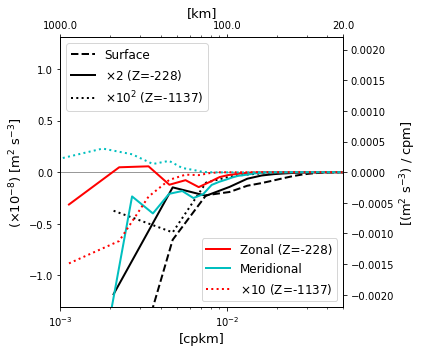

<xarray.DataArray (nmemb: 48, Z: 3, freq_r: 17)>
array([[[ 5.20486539e-09,  4.52155537e-09, -2.26855224e-10, ...,
         -1.09535150e-12, -5.31513543e-13, -1.98093842e-13],
        [ 6.55485324e-09,  5.05950051e-09, -3.86176135e-10, ...,
         -1.12276389e-13, -3.28552494e-14, -8.18371557e-15],
        [ 4.22214705e-10,  2.31731558e-10,  4.28436458e-11, ...,
         -1.99980757e-16,  4.28473480e-18,  1.10574864e-16]],

       [[-1.21755652e-08, -8.39345835e-09, -4.81653571e-09, ...,
         -1.09075280e-13, -2.00821597e-15, -1.37443223e-14],
        [-1.20938560e-09, -2.50013186e-09, -8.07093127e-10, ...,
         -7.41159463e-14, -2.96451951e-14, -1.41914126e-14],
        [ 2.47209614e-11, -1.98289151e-11,  2.14953742e-11, ...,
         -1.17557423e-15, -3.91245084e-16, -1.80764616e-16]],

       [[ 1.27743488e-09,  1.05448462e-08,  4.44429522e-09, ...,
         -3.72835998e-11, -1.69376785e-11, -5.64169961e-12],
        [-1.39894665e-09,  2.33024484e-09,  1.27171165e-09, ...,


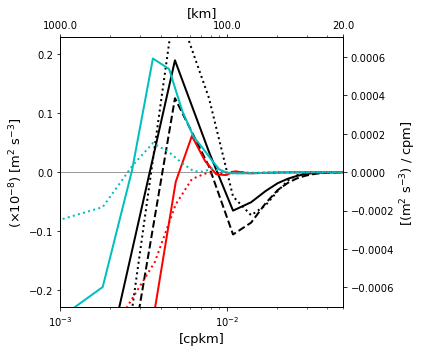

<xarray.DataArray (nmemb: 48, Z: 3, freq_r: 19)>
array([[[ 7.19141510e-09,  1.33199897e-09, -2.43584575e-10, ...,
         -2.86049404e-12, -2.01776652e-12, -1.08760441e-12],
        [ 5.80810399e-09,  1.27090469e-09, -8.06388788e-11, ...,
         -8.90084137e-13, -5.89661686e-13, -2.87832813e-13],
        [ 1.58373312e-11,  1.62109094e-11,  3.25851928e-12, ...,
         -6.91010466e-15, -4.81438806e-15, -2.42214635e-15]],

       [[-1.47243624e-09, -8.50245382e-10, -3.62300095e-11, ...,
         -1.44915074e-12, -7.51209249e-13, -2.90455896e-13],
        [ 1.07880491e-10,  9.37019295e-11,  1.22457602e-10, ...,
         -2.72825692e-13, -1.60718597e-13, -6.35969239e-14],
        [-5.10162060e-12,  2.19289912e-12, -1.17249120e-12, ...,
         -2.40185738e-15, -1.74606152e-15, -7.84321567e-16]],

       [[ 1.59477561e-09,  2.77159218e-10,  2.94000702e-11, ...,
         -2.32734361e-12, -1.55709146e-12, -7.74123313e-13],
        [ 1.79084601e-09,  5.19764451e-10,  3.56197418e-11, ...,


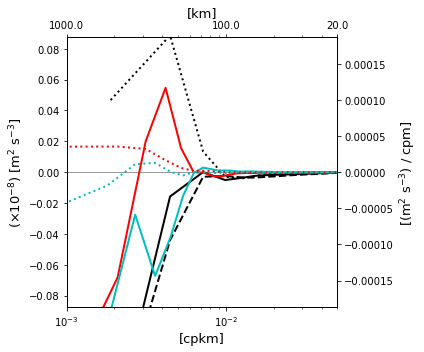

<xarray.DataArray (nmemb: 48, Z: 3, freq_r: 19)>
array([[[-2.24213767e-10,  2.24028923e-11, -4.31485753e-12, ...,
         -1.80604367e-16, -2.15903872e-17, -5.30541854e-17],
        [-1.23248605e-10,  1.88796090e-11,  3.26159088e-12, ...,
         -1.46675347e-17, -5.12403405e-18, -4.95447769e-18],
        [-1.06837242e-12,  1.70645331e-12, -3.98878783e-13, ...,
          6.56745864e-19,  8.17620725e-19,  5.33777515e-19]],

       [[-1.57251243e-11,  2.70415977e-11, -1.06938352e-11, ...,
         -5.64006916e-16, -2.27272545e-16, -6.71470557e-17],
        [-3.06861601e-11, -6.23123437e-12,  2.38804366e-12, ...,
         -1.49974032e-17, -5.48310914e-18, -6.45271448e-19],
        [ 1.92518333e-12,  5.67635190e-13,  2.70970792e-13, ...,
         -3.46870591e-19,  1.57595012e-20, -7.86998268e-20]],

       [[-1.82911473e-10, -1.07986509e-10,  1.39763654e-11, ...,
         -4.86135813e-16, -1.45730888e-16, -8.79463266e-18],
        [ 8.96542754e-11,  5.32158950e-11,  6.87338944e-12, ...,


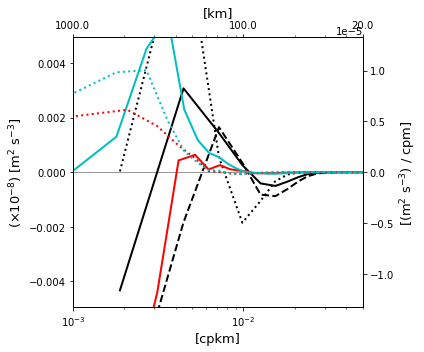

<xarray.DataArray (nmemb: 48, Z: 3, freq_r: 20)>
array([[[-4.57964606e-10, -2.56562725e-12,  9.81113087e-11, ...,
         -6.42701356e-15, -3.04624463e-15, -1.39845765e-15],
        [-2.52761991e-10,  1.86449434e-11,  5.69363926e-11, ...,
         -2.54099206e-16, -9.13050915e-17, -2.79279490e-17],
        [ 9.45724936e-12, -1.14604500e-12, -1.72601622e-13, ...,
          3.82952820e-20, -2.48429027e-20, -2.47613342e-20]],

       [[-1.06103430e-09, -4.62972134e-10, -2.08641758e-11, ...,
         -3.16122875e-14, -1.47236233e-14, -4.92861693e-15],
        [-2.38689121e-10,  1.96996312e-11, -8.52359256e-12, ...,
         -2.57441321e-17, -9.99120995e-18, -2.83654585e-18],
        [-2.85660474e-11, -4.34263486e-12,  7.25564545e-13, ...,
         -7.11414330e-19, -3.02152877e-19, -5.37677987e-20]],

       [[-2.49342769e-10, -8.30762612e-11, -2.75294079e-11, ...,
         -2.16434025e-15, -8.24143745e-16, -3.18780582e-16],
        [-7.51497401e-11, -1.45470894e-11, -1.79871481e-12, ...,


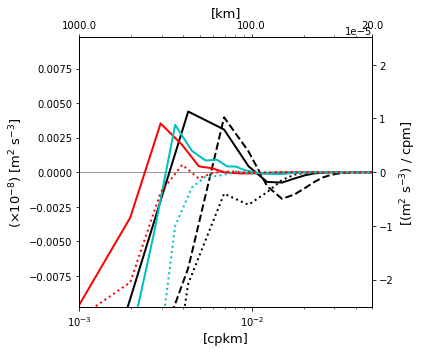

<xarray.DataArray (nmemb: 48, Z: 3, freq_r: 20)>
array([[[-5.82313439e-11,  5.98379538e-11,  7.53119587e-12, ...,
         -5.13588284e-16, -1.52577779e-16, -4.67980449e-17],
        [-2.42076210e-11,  1.91216390e-11,  1.07056725e-11, ...,
         -2.16304173e-18, -3.81470040e-19, -1.56988084e-19],
        [-1.25689679e-11, -2.83075660e-13, -5.55750038e-13, ...,
         -1.78611811e-20,  4.05389542e-20, -3.07077808e-20]],

       [[-1.30892897e-10,  8.75710521e-11,  3.41827830e-11, ...,
          2.04841513e-16,  1.07085706e-16,  5.91199838e-17],
        [ 1.22885189e-11,  3.93195562e-12,  2.99151152e-12, ...,
         -3.26047988e-18, -1.50654726e-18, -6.05557067e-19],
        [-2.28629955e-12, -1.84989713e-12,  1.29129458e-14, ...,
         -4.18300437e-20, -3.94217702e-20, -5.23829710e-21]],

       [[ 6.98019873e-11,  6.18991841e-11, -1.01597097e-12, ...,
         -2.95982601e-16, -2.30958339e-16, -9.60889075e-17],
        [ 3.00552821e-14,  2.60745819e-11, -6.82021282e-12, ...,


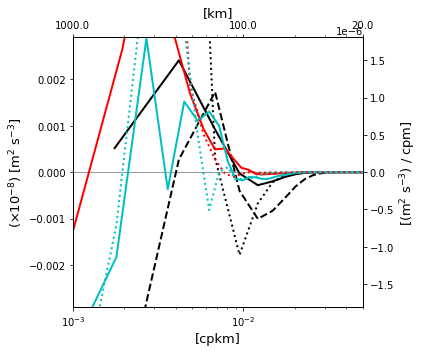

In [22]:
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
xchunk = 100
ychunk = 100

yy = yystart

for reg in range(len(xs)):
    for year in years[yystart:]:
        if year == years[yystart]:
            mtimes = ntimes[yy,:dd+1]
        else:
            mtimes = ntimes[yy]
        for itime in mtimes:

            dsb = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Ensemble-mean/%2dmembers/15N-50N_%010d.zarr'
                                       % (year,len(nmembs),itime))
                              ).isel(time=0
                                    ).sel(YC=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                          YG=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                          XC=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1),
                                          XG=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1)
                                         ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})

            for nmemb in nmembs:
                if nmemb == 0:
                    ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                 % (nmemb,year)), 
                                         grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                         prefix=['diag_ocnTave'], delta_t=2e2,
                                         iters=itime, 
                                        ).sel(YC=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                              YG=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                              XC=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1),
                                              XG=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1)
                                             ).isel(time=0
                                                   ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                else:
                    ds = xr.concat([ds, 
                                    open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                            % (nmemb,year)), 
                                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                    prefix=['diag_ocnTave'], delta_t=2e2,
                                                    iters=itime, 
                                                   ).sel(YC=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                                         YG=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                                         XC=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1),
                                                         XG=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1)
                                                        ).isel(time=0
                                                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                                   ], dim='nmemb')

            # ds = ds.chunk({'nmemb':6})
            ds.coords['nmemb'] = ('nmemb',nmembs)

            grid = Grid(ds, periodic=[])
            
            Au = ((grid.interp(ds.UVEL.where(ds.maskW!=0.),'X',boundary='extend').isel(Z=[0,14,24])
                   * grid.diff((ds.UVEL*ds.dyG).where(ds.maskW!=0.),'X',boundary='extend').isel(Z=[0,14,24])
                   + grid.interp(ds.VVEL.where(ds.maskS!=0.) 
                                 * grid.interp(grid.diff((ds.UVEL*ds.dxC).where(ds.maskW!=0.),'Y',boundary='extend'),
                                               'X',boundary='extend'),
                                 'Y',boundary='extend').isel(Z=[0,14,24])
                  ) / ds.rA).isel(YC=slice(1,-1),XC=slice(1,-1)
                                 ).reset_coords(drop=True).interpolate_na(dim='XC'
                                                                         ).interpolate_na(dim='YC'
                                                                                         ).fillna(0.)
            Av = ((grid.interp(ds.UVEL.where(ds.maskW!=0.) 
                               * grid.interp(grid.diff((ds.VVEL*ds.dyC).where(ds.maskS!=0.),'X',boundary='extend'),
                                             'Y',boundary='extend'),
                               'X',boundary='extend').isel(Z=[0,14,24])
                   + grid.interp(ds.VVEL.where(ds.maskS!=0.),'Y',boundary='extend').isel(Z=[0,14,24])
                   * grid.diff((ds.VVEL*ds.dxG).where(ds.maskS!=0.),'Y',boundary='extend').isel(Z=[0,14,24])
                  ) / ds.rA).isel(YC=slice(1,-1),XC=slice(1,-1)
                                 ).reset_coords(drop=True).interpolate_na(dim='YC'
                                                                         ).interpolate_na(dim='XC'
                                                                                         ).fillna(0.)
#             print(Au,Av)
            
#             fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
#             Au.isel(nmemb=0).plot(ax=ax1)
#             Av.isel(nmemb=0).plot(ax=ax2)
            
            up = grid.interp((ds.UVEL - dsb.UVEL).where(ds.maskW!=0.),
                             'X',boundary='extend'
                            ).isel(Z=[0,14,24],YC=slice(1,-1),XC=slice(1,-1)
                                  ).chunk({'YC':-1,'XC':-1}).interpolate_na(dim='XC'
                                                                           ).interpolate_na(dim='YC'
                                                                                           ).fillna(0.)
            vp = grid.interp((ds.VVEL - dsb.VVEL).where(ds.maskS!=0.),
                             'Y',boundary='extend'
                            ).isel(Z=[0,14,24],YC=slice(1,-1),XC=slice(1,-1)
                                  ).chunk({'YC':-1,'XC':-1}).interpolate_na(dim='YC'
                                                                           ).interpolate_na(dim='XC'
                                                                                           ).fillna(0.)
            Aup = (Au - Au.mean('nmemb',skipna=True)
                  ).chunk({'YC':-1,'XC':-1})
            Avp = (Av - Av.mean('nmemb',skipna=True)
                  ).chunk({'YC':-1,'XC':-1})

            dx = grid.interp(ds.dxC,'X',boundary='extend').mean(skipna=True)
            dy = grid.interp(ds.dyC,'Y',boundary='extend').mean(skipna=True)
            N = up.shape
            up = xr.DataArray(up.data, dims=up.dims, 
                              coords={'nmemb':up.nmemb,
                                      'YC':np.arange(0,N[-2]*dy,dy),
                                      'XC':np.arange(0,N[-1]*dx,dx)}
                             )
            vp = xr.DataArray(vp.data, dims=vp.dims, 
                              coords={'nmemb':vp.nmemb,
                                      'YC':np.arange(0,N[-2]*dy,dy),
                                      'XC':np.arange(0,N[-1]*dx,dx)}
                             )
            Aup = xr.DataArray(Aup.data, dims=Aup.dims, 
                               coords={'nmemb':Aup.nmemb,
                                       'YC':np.arange(0,N[-2]*dy,dy),
                                       'XC':np.arange(0,N[-1]*dx,dx)}
                              )
            Avp = xr.DataArray(Avp.data, dims=Avp.dims, 
                               coords={'nmemb':Avp.nmemb,
                                       'YC':np.arange(0,N[-2]*dy,dy),
                                       'XC':np.arange(0,N[-1]*dx,dx)}
                              )
            
            ntheta=36
            csUA = xrft.cross_spectrum(
                    up, Aup, dim=["YC", "XC"], window='hann', true_phase=True, 
                    window_correction=True
            )
            csVA = xrft.cross_spectrum(
                    vp, Avp, dim=["YC", "XC"], window='hann', true_phase=True, 
                    window_correction=True
            )
            
            cs = (csUA+csVA).real
            pil_0 = (cs.sel(freq_YC=0).isel(freq_XC=slice(int(N[-1]/2)+1,None))*np.diff(cs.freq_XC)[0]
                    )[...,::-1].cumsum('freq_XC')[...,::-1].compute()
            pik_0 = (cs.sel(freq_XC=0).isel(freq_YC=slice(int(N[-2]/2)+1,None))*np.diff(cs.freq_YC)[0]
                    )[...,::-1].cumsum('freq_YC')[...,::-1].compute()
            
            iso_cs = xrft.isotropize(cs, ["freq_YC","freq_XC"], truncate=True)
            pi = (iso_cs*np.diff(iso_cs.freq_r)[0]
                 )[...,::-1].cumsum('freq_r')[...,::-1].compute()
#             pi = -(iso_cs*np.diff(iso_cs.freq_r)[0]).cumsum('freq_r')
            print(pi)
                  
            fig, ax = plt.subplots(figsize=(6,5))
            fig.set_tight_layout(True)
            ax2 = ax.twinx()
            ax3 = ax.twiny()
            ax.plot(np.linspace(1e-3,5e-2,10), np.zeros(10), c='grey', alpha=.8, lw=1)
            ax2.plot(pil_0.freq_XC*1e3, pil_0.isel(Z=1).mean(['nmemb']),
                     'r', lw=2, label=r"Zonal (Z=-228)")
            ax2.plot(pik_0.freq_YC*1e3, pik_0.isel(Z=1).mean(['nmemb']),
                     'c', lw=2, label=r"Meridional")
            ax.plot(pi.freq_r*1e3, pi.isel(Z=0).mean(['nmemb'])*1e8,
                    'k--', lw=2, label=r"Surface")
            ax.plot(pi.freq_r*1e3, pi.isel(Z=1).mean(['nmemb'])*2e8,
                    'k', lw=2, label=r"$\times 2$ (Z=-228)")
            ax.plot(pi.freq_r*1e3, pi.isel(Z=2).mean(['nmemb'])*1e10,
                    'k:', lw=2, label=r"$\times 10^{2}$ (Z=-1137)")
            ax2.plot(pil_0.freq_XC*1e3, pil_0.isel(Z=2).mean(['nmemb'])*1e1,
                     'r:', lw=2, label=r"$\times 10$ (Z=-1137)")
            ax2.plot(pik_0.freq_YC*1e3, pik_0.isel(Z=2).mean(['nmemb'])*1e1,
                     'c:', lw=2)
#             ax.plot((iso_csUA.scale)**-1*1e3, pi.isel(Z=1).mean(['nmemb','angle'])*1e8,
#                     'k:', lw=2, label=r"($\times 10^{-1}$) (Z=-1137)")
#             ax.plot((iso_psUA.scale)**-1*1e3, ((iso_psU.scale/xo)**-1)**-3*6e-2, 
#                      ls='--', c='grey', alpha=.8, label=r"$k^{-3}$")
#             ax.plot((iso_psUA.scale)**-1*1e3, ((iso_psU.scale/xo)**-1)**-(13/3)*6e-2, 
#                      ls='-.', c='grey', alpha=.8, label=r"$k^{-13/3}$")
#             ax2.plot((iso_psUA.scale)**-1*1e3, ((iso_psU.scale/xo)**-1)**-3*6e-2, 
#                      ls='--', c='grey', alpha=0)
            ax.set_xscale('log')
#             ax.set_yscale('log')
#             ax2.set_xscale('log')
            ax3.set_xscale('log')
#             ax2.set_yscale('log')
            ax.set_xlim([1e-3,5e-2])
            ax.set_ylim([-np.abs(pi.isel(Z=0).mean(['nmemb'])).max()*1e8*.5,
                         np.abs(pi.isel(Z=0).mean(['nmemb'])).max()*1e8*.5])
            Mpi = np.fmax(np.abs(pik_0.isel(Z=1).mean(['nmemb'])).max(),
                          np.abs(pil_0.isel(Z=1).mean(['nmemb'])).max())
            ax2.set_ylim([-.5*Mpi, .5*Mpi])
            ax3.set_xlim([1e-3,5e-2])
            ax3.set_xticks([1e-3,1e-2,5e-2])
            ax3.set_xticklabels([1e3,1e2,2e1])
            ax.set_xlabel(r"[cpkm]", fontsize=13)
            ax3.set_xlabel(r"[km]", fontsize=13)
            ax.set_ylabel(r"($\times 10^{-8}$) [m$^2$ s$^{-3}$]", fontsize=13)
            ax2.set_ylabel(r"[(m$^2$ s$^{-3}$) / cpm]", fontsize=13)
#             ax.grid(True)
#             align_yaxis(ax, 0, ax2, 0)
            if reg == 0:
                ax.legend(loc='upper left', fontsize=12)
                ax2.legend(loc='lower right', fontsize=12)
#                 ax2.legend(loc='upper right', fontsize=12)
            
            plt.savefig(op.join(savedir,'Figs/KE-Fourierspecflux_Region%02d.pdf' 
                                % reg))
            plt.show()

In [19]:
da = xr.DataArray(np.arange(10), dims='x', coords={'x':range(10)})
print(da.cumsum('x'))
print(da[::-1].cumsum('x')[::-1])

<xarray.DataArray (x: 10)>
array([ 0,  1,  3,  6, 10, 15, 21, 28, 36, 45])
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9
<xarray.DataArray (x: 10)>
array([45, 45, 44, 42, 39, 35, 30, 24, 17,  9])
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9


In [8]:
def _binned_agg(
    array: np.ndarray,
    indices: np.ndarray,
    num_bins: int,
    *,
    func,
    fill_value,
    dtype,
) -> np.ndarray:
    """NumPy helper function for aggregating over bins."""

    try:
        import numpy_groupies
    except ImportError:
        raise ImportError(
            "This function requires the `numpy_groupies` package to be installed. Please install it with pip or conda."
        )

    mask = np.logical_not(np.isnan(indices))
    int_indices = indices[mask].astype(int)
    shape = array.shape[: -indices.ndim] + (num_bins,)
    result = numpy_groupies.aggregate(
        int_indices,
        array[..., mask],
        func=func,
        size=num_bins,
        fill_value=fill_value,
        dtype=dtype,
        axis=-1,
    )
    return result


def _groupby_bins_agg(
    array: xr.DataArray,
    group: xr.DataArray,
    bins,
    func="sum",
    fill_value=0,
    dtype=None,
    **cut_kwargs,
) -> xr.DataArray:
    """Faster equivalent of Xarray's groupby_bins(...).sum()."""
    # https://github.com/pydata/xarray/issues/4473
    binned = pd.cut(np.ravel(group), bins, **cut_kwargs)
    new_dim_name = group.name + "_bins"
    indices = group.copy(data=binned.codes.reshape(group.shape))

    result = xr.apply_ufunc(
        _binned_agg,
        array,
        indices,
        input_core_dims=[indices.dims, indices.dims],
        output_core_dims=[[new_dim_name]],
        output_dtypes=[array.dtype],
        dask_gufunc_kwargs=dict(
            allow_rechunk=True,
            output_sizes={new_dim_name: binned.categories.size},
        ),
        kwargs={
            "num_bins": binned.categories.size,
            "func": func,
            "fill_value": fill_value,
            "dtype": dtype,
        },
        dask="parallelized",
    )
    result.coords[new_dim_name] = binned.categories
    return result


def isotropize(ps, fftdim, nfactor=4, truncate=False, complx=False):
    """
    Isotropize a 2D power spectrum or cross spectrum
    by taking an azimuthal average.

    .. math::
        \text{iso}_{ps} = k_r N^{-1} \sum_{N} |\mathbb{F}(da')|^2

    where :math:`N` is the number of azimuthal bins.

    Parameters
    ----------
    ps : `xarray.DataArray`
        The power spectrum or cross spectrum to be isotropized.
    fftdim : list
        The fft dimensions overwhich the isotropization must be performed.
    nfactor : int, optional
        Ratio of number of bins to take the azimuthal averaging with the
        data size. Default is 4.
    truncate : bool, optional
        If True, the spectrum will be truncated for wavenumbers larger than
        the Nyquist wavenumber.
    """

    # compute radial wavenumber bins
    k = ps[fftdim[1]]
    l = ps[fftdim[0]]

    N = [k.size, l.size]
    nbins = int(min(N) / nfactor)
    freq_r = np.sqrt(k ** 2 + l ** 2).rename("freq_r")
    kr = _groupby_bins_agg(freq_r, freq_r, bins=nbins, func="mean")

    if truncate:
        if k.max() > l.max():
            kmax = l.max()
        else:
            kmax = k.max()
        kr = kr.where(kr <= kmax)
    else:
        msg = (
            "The flag `truncate` will be set to True by default in future version "
            + "in order to truncate the isotropic wavenumber larger than the "
            + "Nyquist wavenumber."
        )
        warnings.warn(msg, FutureWarning)
    
    if complx:
        iso_ps = (
            _groupby_bins_agg(ps, freq_r, bins=nbins, func="mean", dtype=np.complex128)
            .rename({"freq_r_bins": "freq_r"})
            .drop_vars("freq_r")
        )
    else:
        iso_ps = (
            _groupby_bins_agg(ps, freq_r, bins=nbins, func="mean")
            .rename({"freq_r_bins": "freq_r"})
            .drop_vars("freq_r")
        )
    iso_ps.coords["freq_r"] = kr.data
    if truncate:
        return (iso_ps * iso_ps.freq_r).dropna("freq_r")
    else:
        return iso_ps * iso_ps.freq_r

In [10]:
cs = xrft.cross_spectrum(
                    up, Aup, dim=["YC", "XC"], window='hann', true_phase=True, 
                    window_correction=True
            )
cs

<xarray.DataArray (nmemb: 48, freq_YC: 120, freq_XC: 116)>
dask.array<mul, shape=(48, 120, 116), dtype=complex128, chunksize=(1, 120, 116), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * freq_YC  (freq_YC) float64 -5.397e-05 -5.307e-05 ... 5.217e-05 5.307e-05
  * freq_XC  (freq_XC) float64 -6.549e-05 -6.436e-05 ... 6.323e-05 6.436e-05